In [8]:
#
# Copyright (c) 2023 salesforce.com, inc.
# All rights reserved.
# SPDX-License-Identifier: Apache-2.0
# For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/Apache-2.0
#
"""
File for running all computer vision experiments.
"""
import argparse
from collections import defaultdict
import math
import os
from re import sub

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, LBFGS, SGD
import tqdm

# Our new algorithm
from online_conformal.magnitude_learner import MagnitudeLearner
from online_conformal.mag_learner_undiscounted import MagLearnUndiscounted
from online_conformal.ogd_simple import SimpleOGD

# From previous work
from online_conformal.saocp import SAOCP
from online_conformal.faci import FACI, FACI_S
from online_conformal.nex_conformal import NExConformal
from online_conformal.ogd import ScaleFreeOGD
from online_conformal.split_conformal import SplitConformal
from online_conformal.utils import pinball_loss
from cv_utils import create_model, data_loader
from cv_utils import ImageNet, TinyImageNet, CIFAR10, CIFAR100, ImageNetC, TinyImageNetC, CIFAR10C, CIFAR100C

/Users/davidbombara/Documents/ComputationalRoboticsCode/discounted-adaptive/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
__file__ = "vision.ipynb"

In [ ]:

corruptions = [
    None,
    "brightness",
    "contrast",
    "defocus_blur",
    "elastic_transform",
    "fog",
    "frost",
    "gaussian_noise",
    "glass_blur",
    "impulse_noise",
    "jpeg_compression",
    "motion_blur",
    "pixelate",
    "shot_noise",
    "snow",
    "zoom_blur",
]

def parse_args():
    args = argparse.Namespace
    args.dataset = "TinyImageNet"
    args.model = "resnet50"
    args.lr = 1e-3
    args.batch_size = 256
    args.n_epochs = 150 #default = 150
    args.patience = 10
    #args.ignore_checkpoint = "store_true"
    args.target_cov = 90
    args.ignore_checkpoint = True

    assert 50 < args.target_cov < 100
    args.target_cov = args.target_cov / 100

    # Set up distributed training if desired, and set the device
    args.local_rank = int(os.environ.get("LOCAL_RANK", -1))
    print("args_local_rank = ", args.local_rank)
    if args.local_rank == -1:
        if torch.cuda.is_available():
            args.device = torch.device("cuda")
        else:
            args.device = torch.device("cpu")
        args.world_size = 1
    else:
        dist.init_process_group(backend="nccl")
        args.device = torch.device(args.local_rank)
        args.world_size = dist.get_world_size()
    print("args.devices = ", args.device)
        
    return args

parse_args()

args_local_rank =  -1
args.devices =  cuda


argparse.Namespace

In [ ]:
def get_base_dataset(dataset, split):
    if dataset == "ImageNet":
        return ImageNet(split)
    elif dataset == "TinyImageNet":
        return TinyImageNet(split)
    elif dataset == "CIFAR10":
        return CIFAR10(split)
    elif dataset == "CIFAR100":
        return CIFAR100(split)
    raise ValueError(f"Dataset {dataset} is not supported.")


def get_model_file(args):
    rootdir = os.path.dirname(os.path.abspath(__file__))
    return os.path.join(rootdir, "cv_models", args.dataset, args.model, "model.pt")


def get_model(args):
    if args.dataset != "ImageNet":
        return torch.load(get_model_file(args), map_location=args.device)
    return create_model(dataset=ImageNet("valid"), model_name=args.model, device=args.device)


def get_results_file(args, corruption, severity):
    rootdir = os.path.dirname(os.path.abspath(__file__))
    return os.path.join(rootdir, "cv_logits", args.dataset, args.model, f"{corruption}_{severity}.pt")


def get_temp_file(args):
    return os.path.join(os.path.dirname(get_results_file(args, None, 0)), "temp.txt")


def finished(args):
    for corruption in corruptions:
        for severity in [0] if corruption is None else [1, 2, 3, 4, 5]:
            fname = get_results_file(args, corruption, severity)
            if not os.path.isfile(fname):
                return False
    return os.path.isfile(get_temp_file(args))


def raps_params(dataset):
    if dataset == "CIFAR10":
        lmbda, k_reg, n_class = 0.1, 1, 10
    elif dataset == "CIFAR100":
        lmbda, k_reg, n_class = 0.02, 5, 100
    elif dataset == "TinyImageNet":
        lmbda, k_reg, n_class = 0.01, 20, 200
    elif dataset == "ImageNet":
        lmbda, k_reg, n_class = 0.01, 10, 1000
    else:
        raise ValueError(f"Unsupported dataset {dataset}")
    return lmbda, k_reg, n_class


def train(args):
    # Get train/valid data
    print("Getting training and validation data")
    train_data = get_base_dataset(args.dataset, "train")
    valid_data = get_base_dataset(args.dataset, "valid")

    # Load model checkpoint one has been saved. Otherwise, initialize everything from scratch.
    print("Load model checkpoint one has been saved. Otherwise, initialize everything from scratch.")
    model_file = get_model_file(args)
    ckpt_name = os.path.join(os.path.dirname(model_file), "checkpoint.pt")
    if os.path.isfile(ckpt_name) and not args.ignore_checkpoint:
        model, opt, epoch, best_epoch, best_valid_acc = torch.load(ckpt_name, map_location=args.device)
    else:
        # create save directory if needed
        print("Create a save directory if needed")
        if args.local_rank in [-1, 0]:
            os.makedirs(os.path.dirname(ckpt_name), exist_ok=True)
        model = create_model(dataset=train_data, model_name=args.model, device=args.device)
        if "ImageNet" in args.dataset:
            opt = SGD(model.parameters(), lr=0.1, momentum=0.9)
        else:
            opt = Adam(model.parameters(), lr=args.lr)
        epoch, best_epoch, best_valid_acc = 0, 0, 0.0

    # Set up distributed data parallel if applicable
    print("Set up distributed data parallel if applicable")
    writer = args.local_rank in [-1, 0]
    if args.local_rank != -1:
        model = nn.parallel.DistributedDataParallel(model, device_ids=[args.device])

    for epoch in range(epoch, args.n_epochs):
        # Check early stopping condition
        print("Check early stopping condition")
        if args.patience and epoch - best_epoch > args.patience:
            break

        # Main training loop
        print("Main training loop")
        train_loader = data_loader(dataset=train_data, batch_size=args.batch_size // args.world_size, epoch=epoch)
        for x, y in tqdm.tqdm(train_loader, desc=f"Train epoch {epoch+1:2}/{args.n_epochs}", disable=not writer):
            opt.zero_grad()
            pred = model(x.to(device=args.device))
            loss = F.cross_entropy(pred, y.to(device=args.device))
            loss.backward()
            opt.step()

        # Anneal learning rate by a factor of 10 every 7 epochs
        print("Anneal learning rate by a factor of 10 every 7 epochs")
        if (epoch + 1) % 7 == 0:
            for g in opt.param_groups:
                g["lr"] *= 0.1

        # Obtain accuracy on the validation dataset
        print("Obtain accuracy on the validation dataset")
        valid_acc = torch.zeros(2, device=args.device)
        valid_loader = data_loader(valid_data, batch_size=args.batch_size, epoch=epoch)
        with torch.no_grad():
            for x, y in tqdm.tqdm(valid_loader, desc=f"Valid epoch {epoch + 1:2}/{args.n_epochs}", disable=True):
                pred = model(x.to(device=args.device))
                valid_acc[0] += x.shape[0]
                valid_acc[1] += (pred.argmax(dim=-1) == y.to(device=args.device)).sum().item()

        # Reduce results from all parallel processes
        print("Reduce results from all parallel processes")
        if args.local_rank != -1:
            dist.all_reduce(valid_acc)
        valid_acc = (valid_acc[1] / valid_acc[0]).item()

        # Save checkpoint & update best saved model
        print("Save checkpoints and update best saved model")
        if writer:
            print(f"Epoch {epoch + 1:2} valid acc: {valid_acc:.5f}")
            model_to_save = model.module if args.local_rank != -1 else model
            if valid_acc > best_valid_acc:
                best_epoch = epoch
                best_valid_acc = valid_acc
                torch.save(model_to_save, model_file)
            torch.save([model_to_save, opt, epoch + 1, best_epoch, best_valid_acc], ckpt_name)

        # Synchronize before starting next epoch
        print("Synchronize before starting next epoch")
        if args.local_rank != -1:
            dist.barrier()


def temperature_scaling(args):
    temp = nn.Parameter(torch.tensor(1.0, device=args.device))
    opt = LBFGS([temp], lr=0.01, max_iter=500)
    loss_fn = nn.CrossEntropyLoss()

    n_epochs = 10
    valid_data = get_base_dataset(args.dataset, "valid")
    model = get_model(args)
    for epoch in range(n_epochs):
        valid_loader = data_loader(valid_data, batch_size=args.batch_size, epoch=epoch)
        for x, y in tqdm.tqdm(valid_loader, desc=f"Calibration epoch {epoch + 1:2}/{n_epochs}", disable=False):
            with torch.no_grad():
                logits = model(x.to(device=args.device))

            def eval():
                opt.zero_grad()
                loss = loss_fn(logits / temp, y.to(device=args.device))
                loss.backward()
                return loss

            opt.step(eval)

    return temp.item()


def get_logits(args):
    if args.dataset == "CIFAR10":
        dataset_cls = CIFAR10C
    elif args.dataset == "CIFAR100":
        dataset_cls = CIFAR100C
    elif args.dataset == "TinyImageNet":
        dataset_cls = TinyImageNetC
    elif args.dataset == "ImageNet":
        dataset_cls = ImageNetC
    else:
        raise ValueError(f"Dataset {args.dataset} is not supported.")
    model = None
    print("Dataset: ", dataset_cls)

    print("Applying corruptions: ", corruptions)
    for corruption in tqdm.tqdm(corruptions, desc="Corruptions", position=1):
        print("Corruption: ", corruption)
        severities = [0] if corruption is None else [1, 2, 3, 4, 5]
        print("Applying various severity levels: ", severities)
        for severity in tqdm.tqdm(severities, desc="Severity Levels", position=2, leave=False):
            print("Severity: ", severity)
            fname = get_results_file(args, corruption, severity)
            if os.path.isfile(fname) and not args.ignore_checkpoint:
                continue
            os.makedirs(os.path.dirname(fname), exist_ok=True)
            if model is None:
                model = get_model(args)

            # Save the model's logits & labels for the whole dataset
            print("Save the model's logits & labels for the whole dataset")
            logits, labels = [], []
            dataset = dataset_cls(corruption=corruption, severity=severity)
            loader = data_loader(dataset, batch_size=args.batch_size)
            with torch.no_grad():
                for x, y in loader:
                    logits.append(model(x.to(device=args.device)).cpu())
                    labels.append(y.cpu())
            torch.save([torch.cat(logits), torch.cat(labels)], fname)


def t_to_sev(t, window, run_length=500, schedule=None):
    if t < window or schedule in [None, "None", "none"]:
        return 0
    t_base = t - window // 2
    if schedule == "gradual":
        k = (t_base // run_length) % 10
        return k if k <= 5 else 10 - k
    if schedule == "random_sudden":
        #return np.random.randint(0, 5) * ((t_base // run_length) % 2)
        return np.clip(np.random.randint(0, 10) * ((t_base // run_length) % 2),0,5)
    if schedule == "random_gradual":
        k = (((t_base* abs(np.random.uniform(1,1.5))) // run_length) % 10 ) 
        return (k if k <= 5 else 10 - k) * np.random.randint(1,2) 
    return 5 * ((t_base // run_length) % 2) # default: sudden schedule

Train the model, save its logits on all the corrupted test datasets, and do temperature scaling
args_local_rank =  -1
args.devices =  cuda
Training models
Getting training and validation data
Load model checkpoint one has been saved. Otherwise, initialize everything from scratch.
Create a save directory if needed
Set up distributed data parallel if applicable
Check early stopping condition
Main training loop


Train epoch  1/150: 100%|██████████| 352/352 [02:58<00:00,  1.97it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch  1 valid acc: 0.29940
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch  2/150: 100%|██████████| 352/352 [02:56<00:00,  2.00it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch  2 valid acc: 0.33380
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch  3/150: 100%|██████████| 352/352 [02:57<00:00,  1.98it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch  3 valid acc: 0.35740
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch  4/150: 100%|██████████| 352/352 [02:57<00:00,  1.99it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch  4 valid acc: 0.37760
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch  5/150: 100%|██████████| 352/352 [02:58<00:00,  1.97it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch  5 valid acc: 0.38260
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch  6/150: 100%|██████████| 352/352 [02:58<00:00,  1.97it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch  6 valid acc: 0.39450
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch  7/150: 100%|██████████| 352/352 [02:55<00:00,  2.01it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch  7 valid acc: 0.39250
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch  8/150: 100%|██████████| 352/352 [02:55<00:00,  2.01it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch  8 valid acc: 0.42230
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch  9/150: 100%|██████████| 352/352 [02:56<00:00,  1.99it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch  9 valid acc: 0.42230
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch 10/150: 100%|██████████| 352/352 [02:56<00:00,  2.00it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch 10 valid acc: 0.42060
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch 11/150: 100%|██████████| 352/352 [02:54<00:00,  2.02it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch 11 valid acc: 0.41780
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch 12/150: 100%|██████████| 352/352 [02:56<00:00,  2.00it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch 12 valid acc: 0.42000
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch 13/150: 100%|██████████| 352/352 [02:56<00:00,  2.00it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch 13 valid acc: 0.42000
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch 14/150: 100%|██████████| 352/352 [02:56<00:00,  1.99it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch 14 valid acc: 0.42040
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch 15/150: 100%|██████████| 352/352 [02:58<00:00,  1.98it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch 15 valid acc: 0.41960
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch 16/150: 100%|██████████| 352/352 [02:56<00:00,  2.00it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch 16 valid acc: 0.41870
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch 17/150: 100%|██████████| 352/352 [02:56<00:00,  2.00it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch 17 valid acc: 0.41930
Synchronize before starting next epoch
Check early stopping condition
Main training loop


Train epoch 18/150: 100%|██████████| 352/352 [02:59<00:00,  1.96it/s]


Anneal learning rate by a factor of 10 every 7 epochs
Obtain accuracy on the validation dataset
Reduce results from all parallel processes
Save checkpoints and update best saved model
Epoch 18 valid acc: 0.41810
Synchronize before starting next epoch
Check early stopping condition
Finished training
Getting temp file...
Done
Load the saved logits
Initialize conformal prediction methods, along with accumulators for results
[]


100%|██████████| 7012/7012 [00:04<00:00, 1499.18it/s]


Distribution shift: sudden
ScaleFreeOGD   : Cov: 0.899, Avg Width: 123.7, Avg Miscov: 0.038, Avg Regret: 0.0031
SimpleOGD      : Cov: 0.899, Avg Width: 125.0, Avg Miscov: 0.041, Avg Regret: 0.0031
MagnitudeLearner: Cov: 0.901, Avg Width: 143.2, Avg Miscov: 0.034, Avg Regret: 0.0191
MagLearnUndiscounted: Cov: 0.894, Avg Width: 122.0, Avg Miscov: 0.044, Avg Regret: 0.0034
[]


100%|██████████| 7012/7012 [00:04<00:00, 1503.60it/s]


Distribution shift: gradual
ScaleFreeOGD   : Cov: 0.900, Avg Width: 160.5, Avg Miscov: 0.025, Avg Regret: 0.0018
SimpleOGD      : Cov: 0.900, Avg Width: 161.8, Avg Miscov: 0.026, Avg Regret: 0.0018
MagnitudeLearner: Cov: 0.894, Avg Width: 166.0, Avg Miscov: 0.036, Avg Regret: 0.0209
MagLearnUndiscounted: Cov: 0.897, Avg Width: 160.8, Avg Miscov: 0.034, Avg Regret: 0.0022


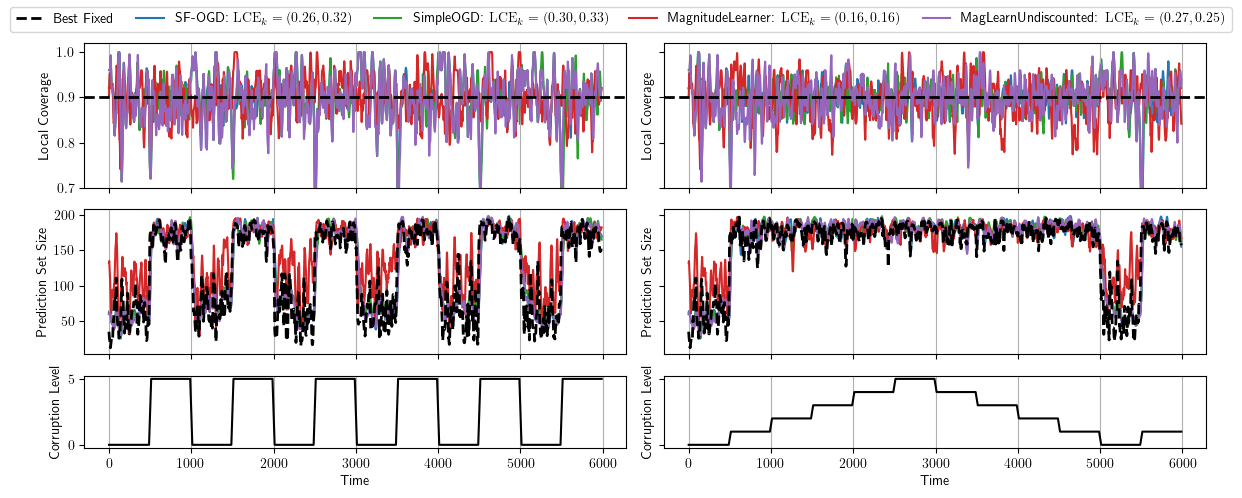

In [ ]:

# Train the model, save its logits on all the corrupted test datasets, and do temperature scaling
print("Train the model, save its logits on all the corrupted test datasets, and do temperature scaling")
args = parse_args()
# if args.dataset != "ImageNet":
if not finished(args) and args.dataset != "ImageNet":
    print("Training models")
    train(args)
    print("Finished training")
if args.local_rank in [-1, 0]:
    print("Getting temp file...")
    temp_file = get_temp_file(args)
    print("Done")
    if not finished(args):
        print("get_logits(args)")
        get_logits(args)
        print("...Done")
        temp = temperature_scaling(args)
        with open(temp_file, "w") as f:
            f.write(str(temp))

    # Load the saved logits
    print("Load the saved logits")
    with open(temp_file) as f:
        temp = float(f.readline())
    n_data = None
    sev2results = defaultdict(list)
    for corruption in corruptions:
        severities = [0] if corruption is None else [1, 2, 3, 4, 5]
        for severity in severities:
            try:
                logits, labels = torch.load(get_results_file(args, corruption, severity))
            except:
                continue
            sev2results[severity].append(list(zip(F.softmax(logits / temp, dim=-1).numpy(), labels.numpy())))
            n_data = len(labels) if n_data is None else min(n_data, len(labels))

    # Initialize conformal prediction methods, along with accumulators for results
    print("Initialize conformal prediction methods, along with accumulators for results")
    lmbda, k_reg, n_class = raps_params(args.dataset)
    D = 1 + lmbda * np.sqrt(n_class - k_reg)
    # methods = [SplitConformal, NExConformal, FACI, ScaleFreeOGD, FACI_S, SAOCP, MagnitudeLearner, MagLearnUndiscounted]
    methods = [ScaleFreeOGD, SimpleOGD, MagnitudeLearner, MagLearnUndiscounted]
    label2err = defaultdict(list)
    plt.rcParams["text.usetex"] = True
    h = 5 + 0.5 * (len(methods) > 5)
    fig, axs = plt.subplots(nrows=3, ncols=2, sharex="col", sharey="row", figsize=(12, h), height_ratios=[4, 4, 2])
    np.random.seed(0)
    for i_shift, shift in enumerate(["sudden", "gradual"]):
        sevs, s_opts, w_opts = [], [], []
        # warmup, window, run_length = 1000, 100, 500 # original code
        warmup, window, run_length = 1000, 25, 1000 # our code
        state = np.random.RandomState(0)
        order = state.permutation(n_data)[: 6 * run_length + window // 2 + warmup]
        coverages, s_hats, widths = [{m.__name__: [] for m in methods} for _ in range(3)]
        predictors = [m(None, None, max_scale = D, lifetime = 32, coverage = args.target_cov) for m in methods]
        t_vec = np.zeros(len(order))
        for t, i in tqdm.tqdm(enumerate(order, start=-warmup), total=len(order)):
            # Get saved results for the desired severity
            # print("Get saved results for the desired severity")
            #sev = t_to_sev(t, window=window, run_length = run_length, schedule = shift)
            sev = t_to_sev(t, window=window, schedule = shift)
            probs, label = sev2results[sev][state.randint(0, len(sev2results[sev]))][i]

            # Convert probability to APS score
            # print("Convert probability to APS score")
            i_sort = np.flip(np.argsort(probs))
            p_sort_cumsum = np.cumsum(probs[i_sort]) - state.rand() * probs[i_sort]
            s_sort_cumsum = p_sort_cumsum + lmbda * np.sqrt(np.cumsum([i > k_reg for i in range(n_class)]))
            w_opt = np.argsort(i_sort)[label] + 1
            s_opt = s_sort_cumsum[w_opt - 1]
            if t >= 0:
                sevs.append(sev)
                s_opts.append(s_opt)
                w_opts.append(w_opt)
                t_vec[t] = t

            # Update all the conformal predictors
            # print("Update all the conformal predictors")
            for predictor in predictors:
                name = type(predictor).__name__
                if t >= 0:
                    _, s_hat = predictor.predict(horizon=1)
                    w = np.sum(s_sort_cumsum <= s_hat)
                    s_hats[name].append(s_hat)
                    widths[name].append(w)
                    coverages[name].append(w >= w_opt)
                predictor.update(ground_truth=pd.Series([s_opt]), forecast=pd.Series([0]), horizon=1)

        # Perform evaluation & produce a pretty graph
        # print("Perform evaluation & produce a pretty graph")
        plot_loss = False
        for ax in axs[:, i_shift]:
            ax.xaxis.grid(True)
            ax.tick_params(axis="both", which="both", labelsize=10)

        ax1, ax2, ax3 = axs[:, i_shift]
        sevs = pd.Series(sevs).rolling(window).mean().dropna()
        w_opts = pd.Series(s_opts if plot_loss else w_opts).rolling(window).quantile(args.target_cov).dropna()
        ax1.set_ylabel("Local Coverage", fontsize=10)
        ax2.set_ylabel("Prediction Set Size", fontsize=10)
        ax3.set_xlabel("Time", fontsize=10)
        ax3.set_ylabel("Corruption Level", fontsize=10)
        # ax1.axhline(args.target_cov, c="k", ls="--", lw=2, zorder=len(methods), label="Best Fixed")
        # ax2.plot(range(len(w_opts)), gaussian_filter1d(w_opts, sigma=2), c="k", ls="--", lw=2, zorder=len(methods))
        # ax3.plot(range(len(sevs)), sevs, c="k")
        ax1.axhline(args.target_cov, c="k", ls="--", lw=2, zorder=len(methods), label="Best Fixed")
        ax2.plot(np.arange(len(w_opts)), gaussian_filter1d(w_opts, sigma=2), c="k", ls="--", lw=2, zorder=len(methods))
        ax3.plot(np.arange(len(sevs)), sevs, c="k")

        s_opts = np.asarray(s_opts)
        int_q = pd.Series(s_opts).rolling(window).quantile(args.target_cov).dropna()
        print(f"Distribution shift: {shift}")
        for i, m in enumerate(methods):
            # Compute various summary statistics
            # print("Compute various summary statistics")
            name = m.__name__ # name of the method (OGD, SAOCP, etc.)
            label = sub("Split", "S", sub("Conformal", "CP", sub("ScaleFree", "SF-", sub("_", "-", name))))
            s_hat = np.asarray(s_hats[name])
            int_cov = gaussian_filter1d(pd.Series(coverages[name]).rolling(window).mean().dropna(), sigma=3)
            int_w = pd.Series(s_hats[name] if plot_loss else widths[name]).rolling(window).mean().dropna()
            int_losses = pd.Series(pinball_loss(s_opts, s_hat, args.target_cov)).rolling(window).mean().dropna()
            opts = [pinball_loss(s_opts[i : i + window], q, args.target_cov).mean() for i, q in enumerate(int_q)]
            int_regret = int_losses.values - np.asarray(opts)
            int_miscov = np.abs(args.target_cov - int_cov)

            # Do the plotting
            # print("Do the plotting")
            color = "C" + str(i + (i > 0) if m is not SAOCP else 1)
            label2err[label].append(f"{np.max(int_miscov):.2f}")
            ax1.plot(range(len(int_cov)), int_cov, zorder=i, label=label, color=color)
            ax2.plot(range(len(int_w)), gaussian_filter1d(int_w, sigma=2), zorder=i, label=label, color=color)
            if min(int_cov) < args.target_cov - 0.2:
                ax1.set_ylim(args.target_cov - 0.2, 1.02)

            print(
                f"{name:15}: "
                f"Cov: {np.mean(coverages[name]):.3f}, "
                f"Avg Width: {np.mean(widths[name]):.1f}, "
                f"Avg Miscov: {np.mean(int_miscov):.3f}, "
                f"Avg Regret: {np.mean(int_regret):.4f}"
            )

    fig.tight_layout()
    labels = []
    lines = axs[0, 0].get_lines()
    for line in lines:
        label = line.get_label()
        if label in label2err:
            label = f"{label}: $\\mathrm{{LCE}}_k = ({','.join(label2err[label])})$"
        labels.append(label)
    ncols = math.ceil(len(lines) / 2) if FACI_S in methods else len(lines)
    fig.subplots_adjust(top=0.92 if ncols == len(lines) else 0.88)
    fig.legend(lines, labels, loc="upper center", ncols=ncols, fontsize=10, columnspacing=1.5)
    figdir = os.path.join(os.path.dirname(os.path.abspath(__file__)), "figures")
    os.makedirs(figdir, exist_ok=True)
    fig.savefig(os.path.join(figdir, f"{args.dataset}.pdf"))